In [1]:
!pip install investpy

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from keras_preprocessing import sequence
from keras.models import Sequential

In [3]:
import investpy
pfe = investpy.get_stock_historical_data(stock = 'PFE' , country = 'United States' , from_date = '01/01/2005' , to_date = '01/12/2020')
pfe.head()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2005-01-03,27.31,27.35,26.45,26.45,46085200,USD
2005-01-04,26.41,26.60,26.03,26.45,38701800,USD
2005-01-05,26.48,26.52,26.15,26.27,27448800,USD
2005-01-06,26.40,26.52,26.28,26.29,20256000,USD
2005-01-07,26.54,26.60,26.27,26.30,22322600,USD


In [4]:
pfe.to_csv('pfe_data.csv')

In [5]:
df = pd.read_csv('pfe_data.csv' , usecols=['Date','Close'] ,parse_dates=True , index_col='Date')

In [6]:
df.head()

,Close
Date,
2005-01-03,26.45
2005-01-04,26.45
2005-01-05,26.27
2005-01-06,26.29
2005-01-07,26.30


##Plot The Close Prices

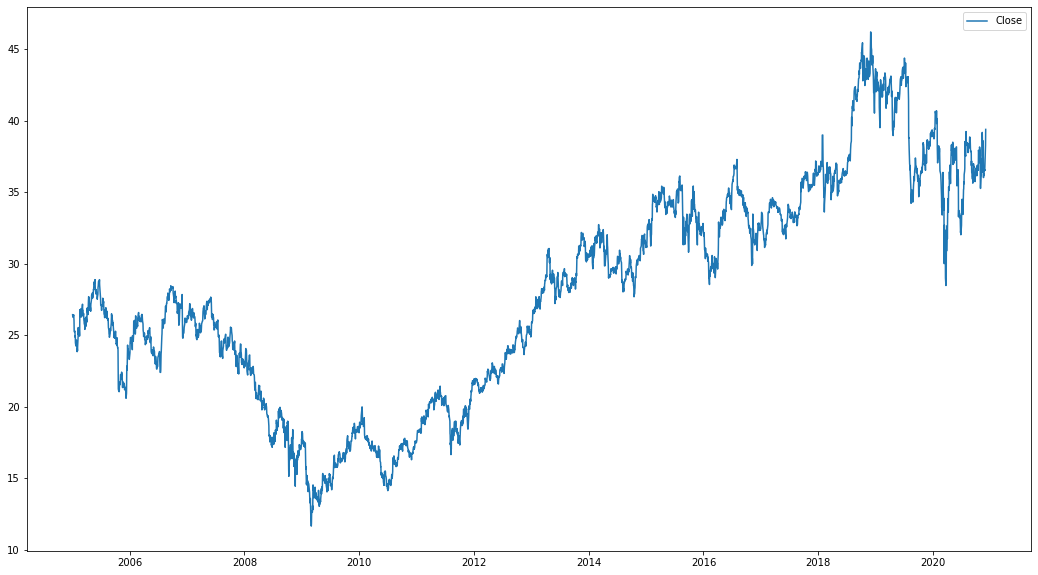

In [7]:
plt.figure(figsize=(18,10))
plt.plot(df['Close'])
plt.legend(['Close'])
plt.show();

##Scale the data and normalize

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
print(scaled_data)

[[0.4278276 ]
 [0.4278276 ]
 [0.42262077]
 ...
 [0.73965866]
 [0.77089962]
 [0.80271912]]


##Make the train and test data

In [10]:
train_length = int(len(scaled_data) * 0.7)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length, :]
test_data = scaled_data[train_length:len(scaled_data), :]

In [11]:
test_data

array([[0.53109633],
       [0.54758461],
       [0.53717096],
       ...,
       [0.73965866],
       [0.77089962],
       [0.80271912]])

## Make the label with numpy array

In [12]:
def create_dataset(dataset, timestep):
  data_x , data_y = [] , []
  for i in range (len(dataset) - timestep - 1):
    data_x.append(dataset[i:(i+timestep) , 0])
    data_y.append(dataset[i+timestep, 0])
  return np.array(data_x) ,np.array(data_y)

In [13]:
timestep = 1
train_x , train_y = create_dataset(train_data , timestep)
test_x , test_y = create_dataset(test_data ,timestep)
print(train_x) #the train_y will be the same 

[[0.4278276 ]
 [0.4278276 ]
 [0.42262077]
 ...
 [0.51981487]
 [0.51750072]
 [0.51576511]]


In [14]:
train_x.shape

(2802, 1)

#Reshape the train to fit the model 

In [15]:
train_x = np.reshape(train_x ,(train_x.shape[0] , 1, train_x.shape[1]))
test_x = np.reshape(test_x ,(test_x.shape[0] ,1, test_x.shape[1]))

print(train_x)

[[[0.4278276 ]]

 [[0.4278276 ]]

 [[0.42262077]]

 ...

 [[0.51981487]]

 [[0.51750072]]

 [[0.51576511]]]


#Build the model

In [16]:
from keras.layers import LSTM , Dense
from keras.callbacks import EarlyStopping

In [17]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1,1)))
model.add(LSTM(50 ,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error' , optimizer = 'adam' , metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [18]:
early_stop = EarlyStopping(monitor='loss', patience=1)

In [19]:
model.fit(train_x , train_y , epochs=200 , verbose=1,callbacks=[early_stop])
score = model.evaluate(train_x, train_y ,verbose=0)
print(f'Keras Model loss = {score[0]*100}')
print(f'Keras Model Accuracy = {score[1]*100}')

Epoch 1/200
88/88 [==============================] - 4s 4ms/step - loss: 0.0339 - accuracy: 3.2962e-05
Epoch 2/200
88/88 [==============================] - 0s 4ms/step - loss: 0.0102 - accuracy: 2.0270e-05
Epoch 3/200
88/88 [==============================] - 0s 4ms/step - loss: 3.6363e-04 - accuracy: 2.2999e-04
Epoch 4/200
88/88 [==============================] - 0s 4ms/step - loss: 3.3553e-04 - accuracy: 5.1754e-04
Epoch 5/200
88/88 [==============================] - 0s 4ms/step - loss: 2.7456e-04 - accuracy: 7.8748e-04
Epoch 6/200
88/88 [==============================] - 0s 4ms/step - loss: 2.5405e-04 - accuracy: 4.5497e-04
Epoch 7/200
88/88 [==============================] - 0s 4ms/step - loss: 2.3334e-04 - accuracy: 9.9139e-05
Epoch 8/200
88/88 [==============================] - 0s 4ms/step - loss: 2.1107e-04 - accuracy: 1.6160e-04
Epoch 9/200
88/88 [==============================] - 0s 4ms/step - loss: 1.8175e-04 - accuracy: 1.9413e-04
Epoch 10/200
88/88 [=========================

In [20]:
train_pred = model.predict(train_x)
test_pred = model.predict(test_x)

print(train_pred)

[[0.42807415]
 [0.42807415]
 [0.42242497]
 ...
 [0.5239819 ]
 [0.5216902 ]
 [0.5199665 ]]


In [21]:
train_pred = scaler.inverse_transform(train_pred)
train_y = scaler.inverse_transform([train_y])
test_pred = scaler.inverse_transform(test_pred)
test_y = scaler.inverse_transform([test_y])

print(train_pred)

[[26.458525]
 [26.458525]
 [26.263231]
 ...
 [29.774055]
 [29.69483 ]
 [29.63524 ]]


In [22]:
train_pred_plot = np.empty_like(scaled_data)
train_pred_plot[:,:] =np.nan
train_pred_plot[1:len(train_pred) +1 , :] = train_pred

In [23]:
test_pred_plot = np.empty_like(scaled_data)
test_pred_plot[:,:] = np.nan
test_pred_plot [len(train_pred)+2 +1:len(scaled_data)-1 , :] = test_pred

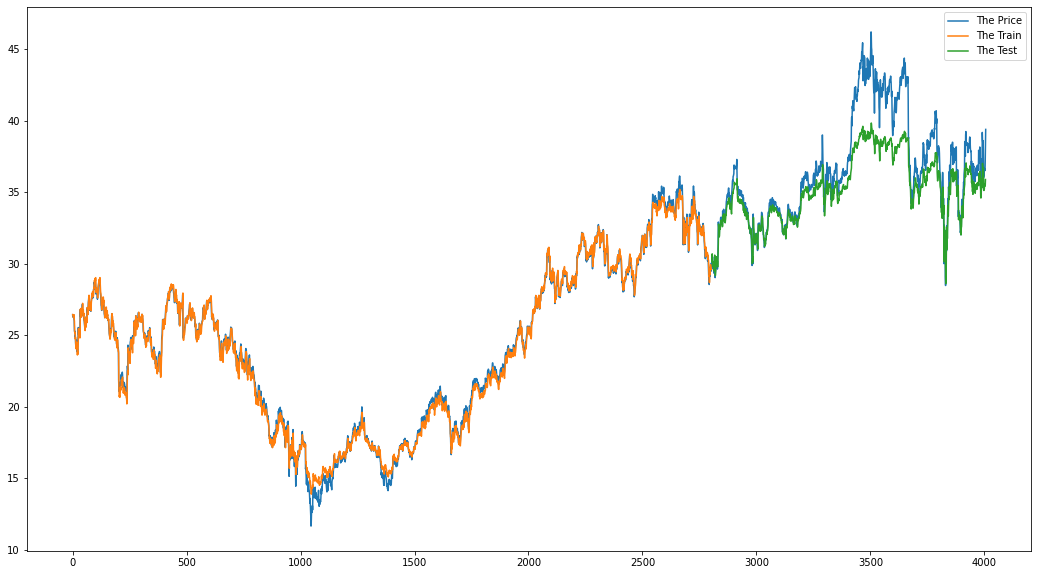

In [24]:
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.legend(['The Price' , 'The Train' , 'The Test'])
plt.show()

In [25]:
model.save('pfe_model.h5')